In [0]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms

In [0]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [0]:
train_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.RandomChoice((transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), transforms.RandomVerticalFlip(), transforms.RandomRotation(0.2))),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
]) 

In [0]:
test_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
])

In [0]:
# !unzip '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset.zip' -d '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/'

In [0]:
train_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/train-cropped"
test_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/test-cropped"
valid_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/valid-cropped"
batch_size = 16
num_workers = 2

In [7]:
cd '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset'

/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset


In [0]:
train_set = datasets.ImageFolder("train-cropped", transform = train_transform)

In [9]:
train_set.classes

['10', '100', '20', '200', '2000', '5', '50', '500', 'none']

In [10]:
type(train_set)

torchvision.datasets.folder.ImageFolder

In [0]:
val_set = datasets.ImageFolder("valid-cropped", transform = test_transform)

In [12]:
val_set

Dataset ImageFolder
    Number of datapoints: 871
    Root location: valid-cropped
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [13]:
val_set.classes

['10', '100', '20', '200', '2000', '5', '50', '500', 'none']

In [0]:
test_set = datasets.ImageFolder("test-cropped", transform = test_transform)

In [15]:
test_set

Dataset ImageFolder
    Number of datapoints: 294
    Root location: test-cropped
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [0]:
trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = num_workers)

In [0]:
val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [0]:
testloader = torch.utils.data.DataLoader(test_set,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [0]:
# dataloaders = {
#     'train' : trainloader,
#     'val' : val_loader
# } 

In [0]:
# total_batch_sizes = {'train' : len(trainloader), 'val' : len(val_loader)}

In [0]:
dataset_sizes = {'train' : len(trainloader), 'val' : len(val_loader)}

In [22]:
dataset_sizes

{'train': 276, 'val': 55}

In [23]:
class_names = train_set.classes

print(np.size(class_names))
print(class_names)

9
['10', '100', '20', '200', '2000', '5', '50', '500', 'none']


#Import Model

In [0]:
from torchvision import models

In [0]:
model = models.mobilenet_v2(pretrained=True)

In [26]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Freezing model parameters of above model

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [28]:
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [0]:
model.classifier  = nn.Sequential( nn.Dropout(p=0.2, inplace=False),
                           nn.Linear(num_ftrs, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(512, 9),
                           nn.LogSoftmax(dim=1))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
print(device)

cuda:0


In [32]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 2

In [34]:
model = model.to(device)

train_loss = list()
val_loss = list()
accuracy = list()

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 / 276
140 / 276
145 / 276
150 / 276
155 / 276
160 / 276
165 / 276
170 / 276
175 / 276
180 / 276
185 / 276
190 / 276
195 / 276
200 / 276
205 / 276
210 / 276
215 / 276
220 / 276
225 / 276
230 / 276
235 / 276
240 / 276
245 / 276
250 / 276
255 / 276
260 / 276
265 / 276
270 / 276
275 / 276
5 / 55
10 / 55
15 / 55
20 / 55
25 / 55
30 / 55
35 / 55
40 / 55
45 / 55
50 / 55
55 / 55
Accuracy of the model on test images: 73.47876004592422%
Epoch: 0 	Training Loss: 7078.003951 	Validation Loss: 743.508102
5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 / 276
140 / 276


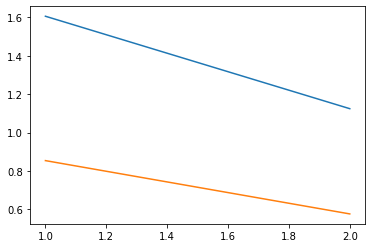

In [36]:
plt.plot([1, 2], train_loss)
plt.plot([1, 2], val_loss)

In [37]:
train_loss

[1.6060821309445639, 1.1242842908373003]

In [40]:
cd '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset'

/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset


In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss[-1],
    'val_loss' : val_loss[-1] 
}, 'Model_checkpoints/mobileNetV2_checkpoint.pth')

In [0]:
checkpoint = torch.load('Model_checkpoints/mobileNetV2_checkpoint.pth')

In [43]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [45]:
start_epoch = checkpoint['epoch']
start_epoch

2

In [46]:
loss = checkpoint['train_loss']
loss

1.1242842908373003

In [47]:
model = model.to(device)
epoch = start_epoch
num_epochs = 20

train_loss = list()
val_loss = list()
accuracy = list()

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 / 276
140 / 276
145 / 276
150 / 276
155 / 276
160 / 276
165 / 276
170 / 276
175 / 276
180 / 276
185 / 276
190 / 276
195 / 276
200 / 276
205 / 276
210 / 276
215 / 276
220 / 276
225 / 276
230 / 276
235 / 276
240 / 276
245 / 276
250 / 276
255 / 276
260 / 276
265 / 276
270 / 276
275 / 276
5 / 55
10 / 55
15 / 55
20 / 55
25 / 55
30 / 55
35 / 55
40 / 55
45 / 55
50 / 55
55 / 55
Accuracy of the model on test images: 82.77841561423651%
Epoch: 0 	Training Loss: 4408.463881 	Validation Loss: 503.611424
5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 / 276
140 / 276


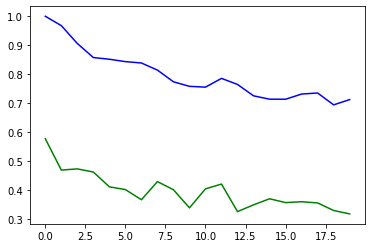

In [53]:
plt.plot(range(0, 20), train_loss, 'b')
plt.plot(range(0, 20), val_loss, 'g')

In [0]:
torch.save({
    'epoch' : 20,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(01).pth')

In [0]:
checkpoint = torch.load('Model_checkpoints/mobileNetV2_checkpoint(01).pth')

In [60]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [62]:
start_epoch = checkpoint['epoch']
start_epoch

20

In [63]:
train_loss = checkpoint['train_loss']
train_loss

[1.0003321718298608,
 0.9679689497154588,
 0.9064579335556351,
 0.8579483316657168,
 0.8521524178473241,
 0.843920588723272,
 0.8392231014003715,
 0.8146474183430767,
 0.7743740858256966,
 0.7587095890722497,
 0.755952377275515,
 0.7861600547711108,
 0.7652296215897654,
 0.7260394971982568,
 0.7144201429206172,
 0.714227411247636,
 0.7321237478365508,
 0.7357303912958266,
 0.6948682225586363,
 0.7130200986232459]

In [0]:
val_loss = checkpoint['val_loss']
accuracy = checkpoint['accuracy']

In [65]:
model = model.to(device)
epoch = start_epoch
num_epochs = 40


for epoch in range(start_epoch, num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {} \tValidation Loss: {}'.format(epoch, trainLoss, valLoss))      

5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 / 276
140 / 276
145 / 276
150 / 276
155 / 276
160 / 276
165 / 276
170 / 276
175 / 276
180 / 276
185 / 276
190 / 276
195 / 276
200 / 276
205 / 276
210 / 276
215 / 276
220 / 276
225 / 276
230 / 276
235 / 276
240 / 276
245 / 276
250 / 276
255 / 276
260 / 276
265 / 276
270 / 276
275 / 276
5 / 55
10 / 55
15 / 55
20 / 55
25 / 55
30 / 55
35 / 55
40 / 55
45 / 55
50 / 55
55 / 55
Accuracy of the model on test images: 89.55223880597015%
Epoch: 20 	Training Loss: 3219.3612886965275 	Validation Loss: 290.46658527851105
5 / 276
10 / 276
15 / 276
20 / 276
25 / 276
30 / 276
35 / 276
40 / 276
45 / 276
50 / 276
55 / 276
60 / 276
65 / 276
70 / 276
75 / 276
80 / 276
85 / 276
90 / 276
95 / 276
100 / 276
105 / 276
110 / 276
115 / 276
120 / 276
125 / 276
130 / 276
135 

In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(02).pth')

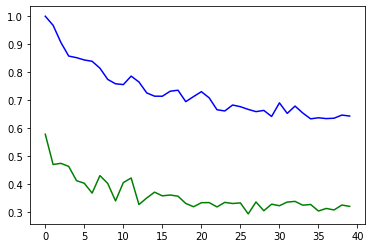

In [68]:
plt.plot(range(40), train_loss, 'b')
plt.plot(range(40), val_loss, 'g')

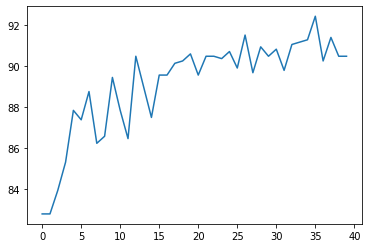

In [69]:
plt.plot(accuracy)

In [71]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0

  for images, labels in testloader:

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on the 1000 test images: {}%".format(100*correct/total))


Accuracy of the model on the 1000 test images: 53.40136054421769%


#Part2


In [0]:
train_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.RandomChoice((transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomRotation(70))),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
]) 

In [0]:
test_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
])

In [0]:
train_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/train-cropped"
test_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/test-cropped"
valid_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/valid-cropped"
batch_size = 64
num_workers = 2

In [76]:
cd '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset'

/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset


In [0]:
train_set = datasets.ImageFolder("train-cropped", transform = train_transform)

In [0]:
val_set = datasets.ImageFolder("valid-cropped", transform = test_transform)

In [0]:
trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = num_workers)

In [0]:
val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [81]:
len(trainloader), len(val_loader)

(69, 14)

In [0]:
model = models.mobilenet_v2(pretrained=True)

In [85]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Freezing model parameters of above model

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [87]:
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [0]:
model.classifier  = nn.Sequential( nn.Dropout(p=0.2, inplace=False),
                           nn.Linear(num_ftrs, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 9),
                           nn.LogSoftmax(dim=1))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [90]:
print(device)

cuda:0


In [91]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 40

In [96]:
model = model.to(device)

train_loss = list()
val_loss = list()
accuracy = list()

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 87.37083811710677%
Epoch: 0 	Training Loss: 2841.295213 	Validation Loss: 327.819233
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 84.1561423650976%
Epoch: 1 	Training Loss: 2214.521286 	Validation Loss: 419.841404
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 86.79678530424799%
Epoch: 2 	Training Loss: 2243.412184 	Validation Loss: 338.554726
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 86.56716417910448%
Epoch: 3 	Training Loss: 2220.943407 	Validation Loss: 336.725502
5 / 69
10 / 69
15 / 69
20 / 69
25 / 6

In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(03G).pth')

In [102]:
model.features[18]

ConvBNReLU(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

In [0]:
for param in model.features[18].parameters():
  param.requires_grad = True

In [0]:
for param in model.features[17].parameters():
  param.requires_grad = True

In [106]:
model = model.to(device)
num_epochs = 2

train_loss = list()
val_loss = list()
accuracy = list()

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 90.01148105625718%
Epoch: 0 	Training Loss: 2036.966856 	Validation Loss: 262.329604
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 95.75200918484501%
Epoch: 1 	Training Loss: 886.934464 	Validation Loss: 113.099131


In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(04G).pth')

In [108]:
model = model.to(device)
num_epochs = 10

train_loss = list()
val_loss = list()
accuracy = list()

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 94.60390355912745%
Epoch: 0 	Training Loss: 915.780501 	Validation Loss: 138.648440
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 95.06314580941446%
Epoch: 1 	Training Loss: 617.191773 	Validation Loss: 149.571156
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 96.44087256027555%
Epoch: 2 	Training Loss: 578.340790 	Validation Loss: 83.916644
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 95.98163030998852%
Epoch: 3 	Training Loss: 468.427953 	Validation Loss: 96.313556
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 

In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(05G).pth')

In [111]:
model.eval()
counter = 0
valLoss = 0
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)
    _, predicted = torch.max(output.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(val_loader))
print("Accuracy of the model on test images: {}%".format(100*correct/total))      

5 / 14
10 / 14
Accuracy of the model on test images: 96.90011481056257%


In [112]:
model.eval()
counter = 0
valLoss = 0
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)
    _, predicted = torch.max(output.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(testloader))
print("Accuracy of the model on test images: {}%".format(100*correct/total))      

5 / 19
10 / 19
15 / 19
Accuracy of the model on test images: 59.183673469387756%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(0)
Predicted  tensor(0, device='cuda:0')


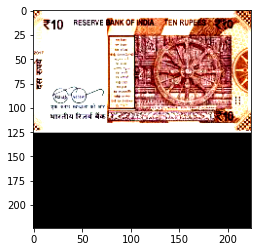

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(0)
Predicted  tensor(0, device='cuda:0')


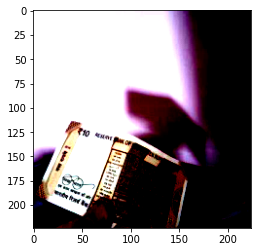

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(1)
Predicted  tensor(1, device='cuda:0')


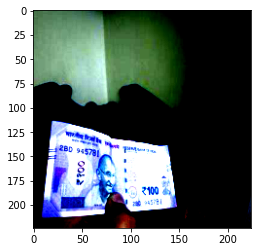

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(2)
Predicted  tensor(2, device='cuda:0')


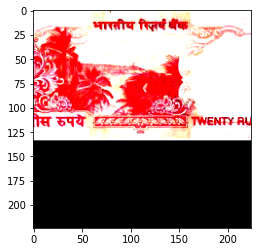

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(2)
Predicted  tensor(2, device='cuda:0')


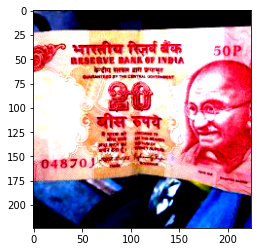

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(3)
Predicted  tensor(3, device='cuda:0')


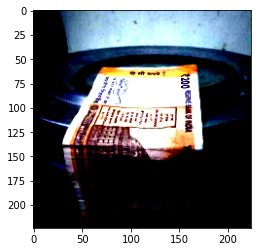

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(5)
Predicted  tensor(5, device='cuda:0')


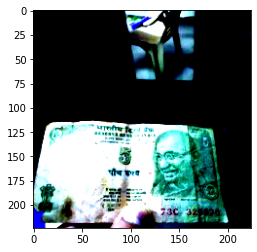

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(5)
Predicted  tensor(5, device='cuda:0')


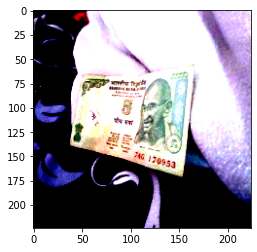

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(6)
Predicted  tensor(6, device='cuda:0')


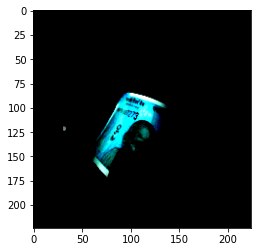

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(7)
Predicted  tensor(7, device='cuda:0')


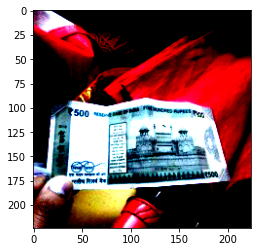

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(7)
Predicted  tensor(7, device='cuda:0')


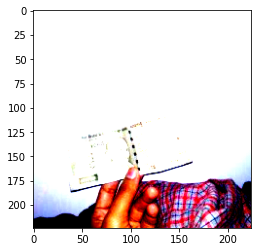

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(7)
Predicted  tensor(7, device='cuda:0')


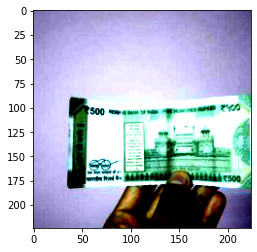

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(8)
Predicted  tensor(8, device='cuda:0')


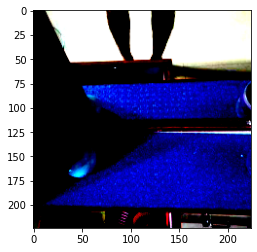

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Ouptut  tensor(8)
Predicted  tensor(8, device='cuda:0')


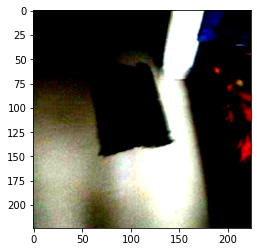

In [118]:
i=0
for inputs, labels in val_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)  

  output = model.forward(inputs)
  _, predicted = torch.max(output.data, 1)

  img = inputs[i]
  img = img.cpu()
  label = labels[i]
  label = label.cpu()
  plt.imshow((img.numpy()).transpose(1, 2, 0))
  print("True Ouptut ", label)
  print("Predicted ", predicted[i])
  plt.show()
  i += 1